In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt
import collections
import nest_asyncio
%reload_ext tensorboard
nest_asyncio.apply()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

In [2]:
class server:
    
    def __init__(self, numOfClients):
        self.numOfClients = numOfClients #Num of Client
        self.clientIds = list(range(0,self.numOfClients)) #Client List
        self.updateRoundNum = 0  # Update Round Number
        self.serverModel = self.createBaseModel() #Create a Keras Model for MNIST
        self.clientActive = [] #If client is available or not based on time - day/night
        self.clientCIF = []
        self.updateFromClients=[]
        self.__serverTestData_X=[]
        self.__serverTestData_Y=[]
        self.predictionAcc=[]
        self.predictionLoss=[]
        
        
    def createBaseModel(self):
        return tf.keras.models.Sequential([
            Dense(64, activation='relu',input_shape=(784,)),
            Dense(64, activation='relu'),
            Dense(10, activation='softmax'),])
    
    def setServerTestData(self,Xtest,Ytest):
        self.__serverTestData_X=Xtest
        self.__serverTestData_Y=Ytest
    
    def initialBroadcast(self):
        for i in self.clientIds:
            clientName = "client_"+str(self.clientIds[i])  #Create Client Name
            #print(clientName)
            eval(clientName).setInitialModel(self.serverModel) #setInitialModel-> Method of client Class
            
    def getClientActiveStatus(self):  #if the client is available for update or not randomly set in client
        self.clientActive = []
        for i in self.clientIds:
            clientName = "client_"+str(self.clientIds[i])  #Create Client Name
            #print(clientName)
            if(eval(clientName).sendActiveStatus() == 1): #getActiveStatus() -> method of client class
                self.clientActive.append(i)
        print("Active Clients: ",self.clientActive)
            
    def getClientCIF(self): # Get Client Importance Factor for active clients
        self.clientCIF=[]
        for i in self.clientActive:
            clientName = "client_"+str(i)
            c_cif = eval(clientName).sendCIF()   #sendCIF() - method of client
            self.clientCIF.append(c_cif)
        print("Clients with Acceptable CIF: ", self.clientCIF)
    
    def getModelUpdateFromClients(self):
        print("--------------------------------------------\n","Round NO:",self.updateRoundNum)
        self.updateRoundNum +=1
        self.updateFromClients=[]
        #self.dataPointsClients=[]
        for i in range (0,len(self.clientActive)):
            if self.clientCIF[i] >= 10:  #Select Client only if CIF > some value 10 chosen for testing ONLY
                clientName = "client_"+str(int(self.clientActive[i]))
                self.updateFromClients.append(eval(clientName).sendClientUpdate()) #Get a list of updates from selected clients
                #print(updateFromClients)
        
        avgModelWeights = self.computeFedAvg(self.updateFromClients)
        #print("average model weights = \n",avgModelWeights)
        self.serverModel.set_weights(avgModelWeights)   
        
    def computeFedAvg(self,updates):  #Compute Federated Averaging from Available Clients
        totalDataPoints = 0
        scaleFactor=[]
        for i in range (0,len(updates)):
            totalDataPoints += updates[i][1]   #Sum the total Data Points on All Available Clients
            scaleFactor.append(updates[i][1])  #Store individual number datapoints for clients
        #print(totalDataPoints)
        #print(scaleFactor)
        
        
        scaleFactor = np.array(scaleFactor)/totalDataPoints #Create the scale factor
        #print(scaleFactor)
        #print(type(scaleFactor))
        
        #for i in range (0,len(updates)):    #Iteration Over the Clients 
        #    for j in range (0,len(updates[i][0])):
        #        updates[i][0][j]=updates[i][0][j]*scaleFactor[i]
        
        sumOfAvgWeights = []*len(updates[0][0]) 
        
        for j in range (0,len(updates[0][0])): #range of layers
            k=np.zeros_like(updates[0][0][j])
            #print("ShapeofK:",k.shape)
            for i in range(0,len(updates)): #range of clients
                k=k+updates[i][0][j]*scaleFactor[i]
                #print("ShapeofK:",k.shape)
            sumOfAvgWeights.append(k)
        
        #print(len(sumOfAvgWeights))
        #print("Size 0",sumOfAvgWeights[0].shape)
        #print("Size 1",sumOfAvgWeights[1].shape)
        #print("Size 2",sumOfAvgWeights[2].shape)
        #print("Size 3",sumOfAvgWeights[3].shape)
        #print("Size 4",sumOfAvgWeights[4].shape)
        #print("Size 5",sumOfAvgWeights[5].shape)
        
        
        return sumOfAvgWeights   
    
    def testServerModel(self):
        #loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        #prediction = self.serverModel.predict(self.__serverTestData_X)
        #self.predictionLoss.append(loss(self.__serverTestData_Y,prediction))
        #self.predictionAcc.append(accuracy_score(tf.argmax(logits, axis=1), tf.argmax(self.__serverTestData_Y, axis=1)))
        return self.serverModel.evaluate(self.__serverTestData_X,to_categorical(self.__serverTestData_Y),batch_size=64)
       # print("Round:",self.updateRoundNum,
        #      "TestAcc:",self.predictionAcc[self.updateRoundNum],
         #    "TestLoss:",self.predictionLoss[self.updateRoundNum])
        
        
    def updateAllClients(self):
        for i in self.clientIds:
            clientName = "client_"+str(self.clientIds[i])  #Create Client Name
            eval(clientName).setModelUpdateWeights(self.serverModel.get_weights()) 



In [ ]:
print(len(serverFA.updateFromClients))
print(serverFA.updateFromClients)

In [ ]:
print((serverFA.updateFromClients[1][0][0])*2)
print(len(serverFA.updateFromClients[1][0]))

In [ ]:
print(type(serverFA.serverModel.get_weights()))

In [ ]:
serverFA.serverModel.evaluate(originalTestX,to_categorical(originalTestY))

In [3]:
class client:
    
    def __init__(self,ID):
        self.id = ID
        self.__clientModel = tf.keras.models.Sequential()
        self.activeStatus = 0
        self.__clientDataX=[] #Private to Client
        self.__clientDataY=[]
        self.clientCIF=0
        self.SNR = 0
        self.epochs = 10
        self.lr = 0.0001
        
    #Methods Private to client
    def __setActiveStatus(self): 
        self.activeStatus = int(np.random.randint(0,2,1))
        #self.activeStatus = 1
    
    def __setCIF(self):
        self.clientCIF = int(np.random.randint(0,50,1))  # Random Number between 0 and 49 for vheck purpose only
        #self.clientCIF = 20
        
    def __getTrainData(self):
        return self.__clientDataX, self.__clientDataY  # Just for Testing will be expanded to select meaningful data
    
    #Public Methods
    def sendActiveStatus(self):
        self.__setActiveStatus()
        return self.activeStatus
    
    def sendCIF(self):
        self.__setCIF()
        return self.clientCIF
    
    def setInitialModel(self,model):
        self.__clientModel=model
         
    def setClientData(self,X,Y):
        self.__clientDataX = X
        self.__clientDataY = Y
   

    def sendClientUpdate(self):
        print("Training Client ID:",self.id)
        self.__clientModel.compile(loss = 'categorical_crossentropy',
                                optimizer = tf.keras.optimizers.SGD (learning_rate=self.lr),
                                metrics=['accuracy'])
        #print(self.__clientDataX.shape)
        #print(self.__clientDataY.shape)
        self.__clientModel.fit(self.__clientDataX,
                               tf.keras.utils.to_categorical(self.__clientDataY),
                               epochs=self.epochs,
                               validation_split=0.2,
                               verbose=0)
        
        updatedWeights = self.__clientModel.get_weights()
        #print("Client_",self.id," weights=\n",updatedWeights)
        #print("Size Client 0",updatedWeights[0].size)
        #print("Size Client 1",updatedWeights[1].size)
        ##print("Size Client 2",updatedWeights[2].size)
        #print("Size Client 3",updatedWeights[3].size)
        #print("Size Client 4",updatedWeights[4].size)
        #print("Size Client 5",updatedWeights[5].size)
        
        numOfDataPoints = self.__clientDataY.size   #<-- Set the correct type to get the number of datapoints in the current update round
        #print("ModelWeightShape=",len(updatedWeights))
        #print("numOfDataPoints=",numOfDataPoints)
        return (updatedWeights,numOfDataPoints)
    
    def setModelUpdateWeights(self,modelUpdateWeights):
        self.__clientModel.set_weights(modelUpdateWeights)
        #self.__clientModel.
        
    def plotClientData(self):
        #print("Y_Data",self.__clientDataY)
        id0=[]
        id1=[]
        id2=[]
        id3=[]
        id4=[]
        id5=[]
        id6=[]
        id7=[]
        id8=[]
        id9=[]
        for i in range (0,len(self.__clientDataY)):
            for j in range (0,10):
                if j==self.__clientDataY[i]:
                    eval('id'+str(j)).append(i)
        xAxis=['0','1','2','3','4','5','6','7','8','9']
        yAxis=[len(id0),len(id1),len(id2),len(id3),len(id4),len(id5),len(id6),len(id7),len(id8),len(id9)]
        plt.bar(xAxis,yAxis)
        title="Data for Client"+str(self.id)
        plt.title(title)
        plt.show()

## Create NON-IID DataSet for Distribution to Client
## Use MNIST Test Dataset for server validation

In [6]:
# Data Modulation 
(originalTrainX, originalTrainY), (originalTestX, originalTestY) = mnist.load_data()

originalTrainX = (originalTrainX / 255) - 0.5
originalTestX = (originalTestX / 255) - 0.5

originalTrainX = originalTrainX.reshape((-1, 784))
originalTestX = originalTestX.reshape((-1, 784))

def distributeDataToClient(numOfClients,X_train,Y_train):  # Creating NON IID DataSet from Original MNIST Train Data
        id0=[]
        id1=[]
        id2=[]
        id3=[]
        id4=[]
        id5=[]
        id6=[]
        id7=[]
        id8=[]
        id9=[]
        for i in range (0,60000):
            for j in range (0,10):
                if j==originalTrainY[i]:
                    eval('id'+str(j)).append(i)
        for i in range(0,10):
            print("Number of Samples for id",str(i),":",len(eval("id"+str(i))))
        
        
        for i in range (0,numOfClients):
            Y_data = []
            X_data = []
            np.random.seed(i*10)
            numOfClasses = int(np.random.randint(4,10,1))        #Select Random Number of Classes e.g 6 classes
            classList = np.random.randint(0,10,numOfClasses)     #Select Random Classes based on above num eg. [0,3,4,5,6,7]
            #print(classList)
            for k in range (0,numOfClasses):
                classID = int(classList[k])
                classIDLen = len(eval("id"+str(classID)))
                #print(classID,":",classIDLen)
                numOfSamplesInClass= int(np.random.randint(1500,5000,1))
                #print(numOfSamplesInClass)
                Y_data = np.empty([numOfSamplesInClass,])
                X_data= np.empty([numOfSamplesInClass,784])
                Y_data = np.random.choice(Y_train,numOfSamplesInClass,replace=False)
                #print(Y_data)
                for n in range(Y_data.size):
                    X_data[n] = np.copy(X_train[n])

            clientName = "client_"+str(i)
            c_data = (X_data,Y_data)
            eval(clientName).setClientData(X_data,Y_data)
            #print(X_data.shape,Y_data.shape)
            print(type(X_data),type(Y_data))
            #print(Y_data)

def distributeDataToServer(serverName,X_test,Y_test):  #Use the mnist test data for server validation
    serverName.setServerTestData(X_test,Y_test)

In [ ]:
client_0.__setCIF()

In [ ]:
#Show the distribution of samples in each class of MNIST
id0=[]
id1=[]
id2=[]
id3=[]
id4=[]
id5=[]
id6=[]
id7=[]
id8=[]
id9=[]
for i in range (0,60000):
    for j in range (0,10):
        if j==originalTrainY[i]:
            eval('id'+str(j)).append(i)
for i in range(0,10):
    print("Number of Samples for id",str(i),":",len(eval("id"+str(i))))

## Initializing Clients

Number of Samples for id 0 : 5923
Number of Samples for id 1 : 6742
Number of Samples for id 2 : 5958
Number of Samples for id 3 : 6131
Number of Samples for id 4 : 5842
Number of Samples for id 5 : 5421
Number of Samples for id 6 : 5918
Number of Samples for id 7 : 6265
Number of Samples for id 8 : 5851
Number of Samples for id 9 : 5949
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'nump

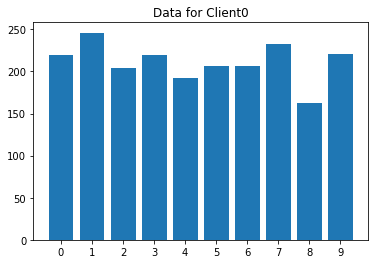

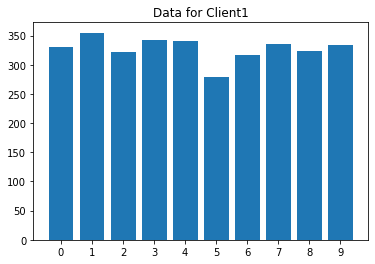

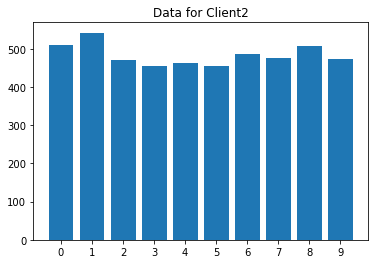

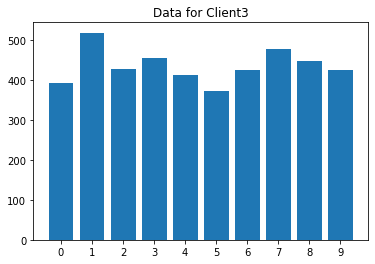

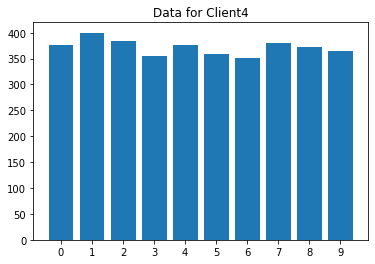

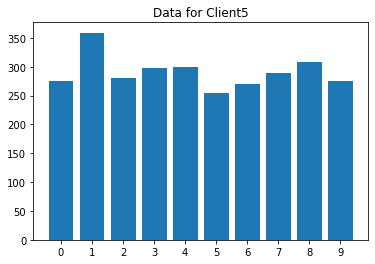

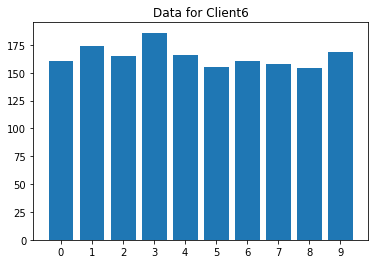

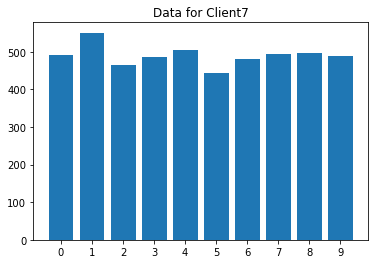

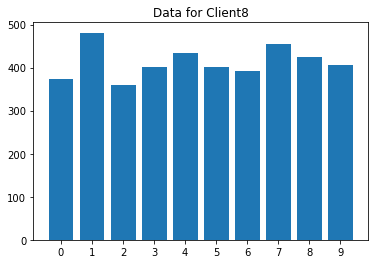

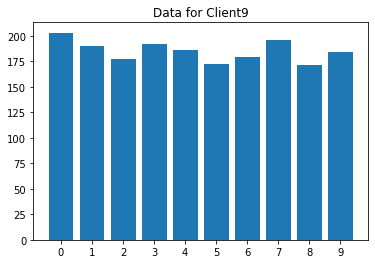

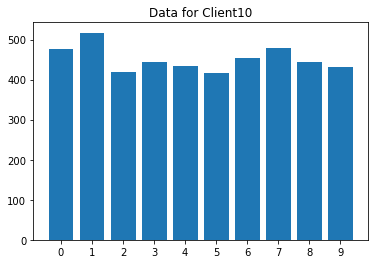

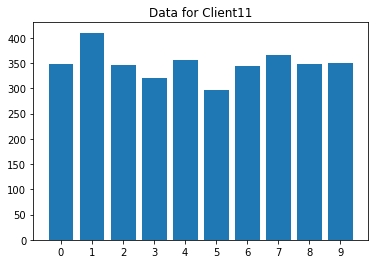

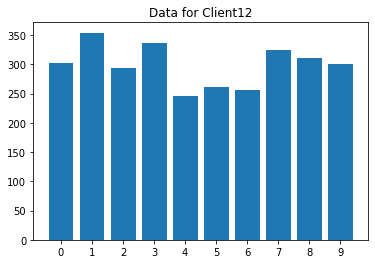

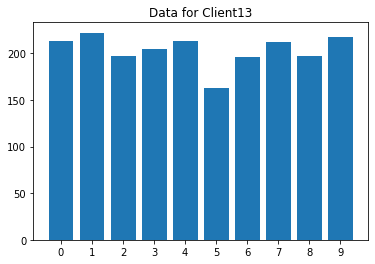

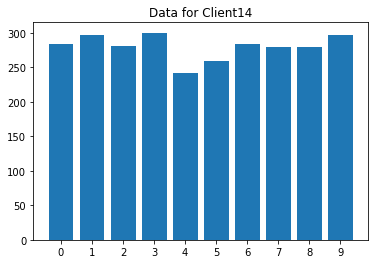

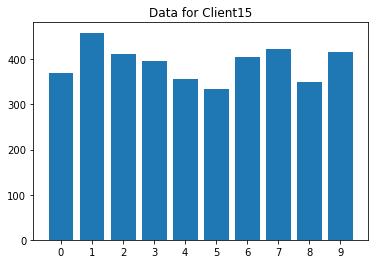

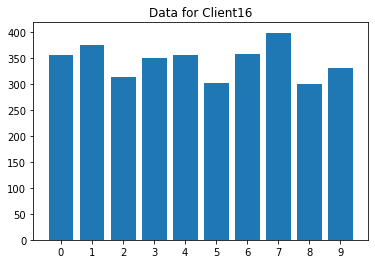

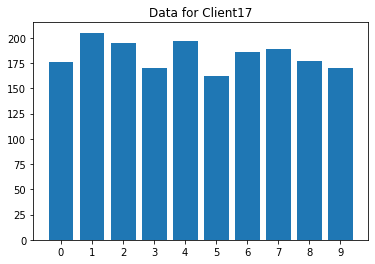

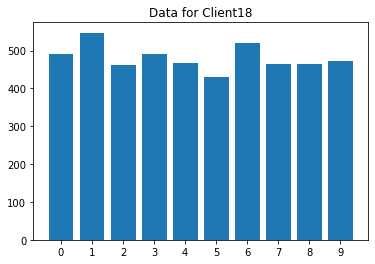

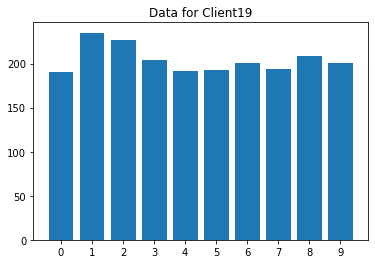

In [7]:
#Populate Clients
N = 20

client_0=client(0)
client_1=client(1)
client_2=client(2)
client_3=client(3)
client_4=client(4)
client_5=client(5)
client_6=client(6)
client_7=client(7)
client_8=client(8)
client_9=client(9)
client_10=client(10)
client_11=client(11)
client_12=client(12)
client_13=client(13)
client_14=client(14)
client_15=client(15)
client_16=client(16)
client_17=client(17)
client_18=client(18)
client_19=client(19)

# Distribute Client Data
distributeDataToClient(N,originalTrainX,originalTrainY)
for i in range (0,N):
    clientName = "client_"+str(i)
    eval(clientName).plotClientData()

### Initializing Sever

In [8]:
serverFA = server(N)   # N = Number of Client
distributeDataToServer(serverFA,originalTestX,originalTestY)

In [9]:
serverFA.initialBroadcast()

In [10]:
numberOfTraingRounds = 20
trainingMetrics=[]*numberOfTraingRounds
for i in range(0,numberOfTraingRounds):
    serverFA.getClientActiveStatus()
    serverFA.getClientCIF()
    serverFA.getModelUpdateFromClients()
    trainingMetrics.append(serverFA.testServerModel())
    serverFA.updateAllClients()


Active Clients:  [1, 2, 3, 4, 5, 8, 9, 10, 11, 13, 14, 15, 17, 18]
Clients with Acceptable CIF:  [46, 20, 1, 19, 19, 2, 29, 49, 46, 47, 31, 14, 12, 1]
--------------------------------------------
 Round NO: 0
Training Client ID: 1
Training Client ID: 2
Training Client ID: 4
Training Client ID: 5
Training Client ID: 9
Training Client ID: 10
Training Client ID: 11
Training Client ID: 13
Training Client ID: 14
Training Client ID: 15
Training Client ID: 17
157/157 [==============================] - 0s 920us/step - loss: 2.3564 - accuracy: 0.0601
Active Clients:  [1, 2, 4, 5, 7, 8, 11, 13, 15, 18, 19]
Clients with Acceptable CIF:  [26, 1, 42, 17, 41, 15, 2, 17, 19, 41, 1]
--------------------------------------------
 Round NO: 1
Training Client ID: 1
Training Client ID: 4
Training Client ID: 5
Training Client ID: 7
Training Client ID: 8
Training Client ID: 13
Training Client ID: 15
Training Client ID: 18
157/157 [==============================] - 0s 946us/step - loss: 2.3489 - accuracy: 0.0

Training Client ID: 3
Training Client ID: 4
Training Client ID: 10
Training Client ID: 11
Training Client ID: 12
Training Client ID: 14
Training Client ID: 16
Training Client ID: 17
Training Client ID: 18
157/157 [==============================] - 0s 1ms/step - loss: 2.3346 - accuracy: 0.0742
Active Clients:  [0, 3, 5, 9, 11, 15, 16, 18]
Clients with Acceptable CIF:  [27, 37, 1, 10, 30, 21, 17, 42]
--------------------------------------------
 Round NO: 19
Training Client ID: 0
Training Client ID: 3
Training Client ID: 9
Training Client ID: 11
Training Client ID: 15
Training Client ID: 16
Training Client ID: 18
157/157 [==============================] - 0s 1ms/step - loss: 2.3336 - accuracy: 0.0780


In [15]:
print(trainingMetrics[0][1])

0.060100000351667404


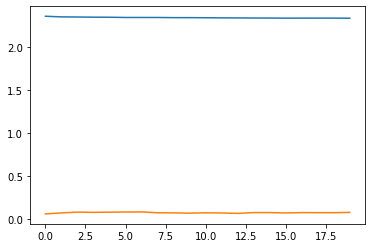

In [17]:

plt.plot(trainingMetrics)

In [ ]:
a.baseModel.set_weights(avgWeight)

In [ ]:
a.baseModel.get_weights()

In [ ]:
evaldata=serverFA.testServerModel()

In [ ]:
type(evaldata)

In [ ]:
evaldata

In [ ]:
#Populate Clients
N = 20

client_0=client(0)
client_1=client(1)
client_2=client(2)
client_3=client(3)
client_4=client(4)
client_5=client(5)
client_6=client(6)
client_7=client(7)
client_8=client(8)
client_9=client(9)
client_10=client(10)
client_11=client(11)
client_12=client(12)
client_13=client(13)
client_14=client(14)
client_15=client(15)
client_16=client(16)
client_17=client(17)
client_18=client(18)
client_19=client(19)

def distributeDataToClient(numOfClients,X_train,Y_train):
    
        for i in range (0,numOfClients):
            np.random.seed(i*10)
            numOfClasses = int(np.random.randint(4,10,1))
            classList = np.random.randint(0,10,numOfClasses)
            print(classList)
            for k in range (0,numOfClasses):
                classID = int(classList[k])
                classIDLen = len(eval("id"+str(classID)))
                #print(classID,":",classIDLen)
                numOfSamplesInClass= int(np.random.randint(200,1000,1))
                #print(numOfSamplesInClass)
                Y_data = np.empty([numOfSamplesInClass,])
                X_data= np.empty([numOfSamplesInClass,784])
                Y_data = np.random.choice(Y_train,numOfSamplesInClass,replace=False)
                #print(Y_data)
                for n in range(Y_data.size):
                    X_data[n] = np.copy(X_train[n])

            clientName = "client_"+str(i)
            c_data = (X_data,Y_data)
            eval(clientName).setClientData(X_data,Y_data)
            print(X_data.shape,Y_data.shape)

def distributeDataToServer(serverName,X_test,Y_test):
    serverName.setServerTestData(X_test,Y_test)
    
distributeDataToClient(20,originalTrainX,originalTrainY)
distributeDataToServer(serverFA,originalTestX,originalTestY)
        

In [ ]:
("client_",1)

In [ ]:
client_0.sendClientUpdate()

In [ ]:
client_0.sendClientUpdate()